# Mini competition for Data Science retreat

This Jupyter notebook contains the code to classify the damage_grades from the [Richter's Predictor: Modeling Earthquake Damage](https://www.drivendata.org/competitions/57/nepal-earthquake/) competition. The competition is hosted on [DrivenData](https://www.drivendata.org/competitions/57/nepal-earthquake/). The goal of the competition is to predict the level of damage to buildings caused by the 2015 Gorkha earthquake in Nepal. The data is provided by [Kathmandu Living Labs](http://www.kathmandulivinglabs.org/).

# Import Data

First we import the data from the csv file. We use the pandas library to read the csv file and store it in a dataframe.

In [1]:
import sys

sys.path.append("../src")

import importer

raw_train_values, raw_train_labels, raw_test_values = importer.import_data(directory="../Data")

# Print the shapes of the data
print("Train values shape: ", raw_train_values.shape)
print("Train labels shape: ", raw_train_labels.shape)
print("Test values shape: ", raw_test_values.shape)


Train values shape:  (260601, 39)
Train labels shape:  (260601, 2)
Test values shape:  (86868, 39)


# Encode Data


BinaryEncoder transforms categorical data by first mapping each category to a unique integer. Then this integer is converted to binary digits. Each binary digit forms a separate column, resulting in log(base 2) of the total unique categories many columns. For geographic data with more than 10K unique values, one-hot encoding would create a lot of columns, significantly increasing dimensionality.

Instead, BinaryEncoder creates only 14 columns (log2(10K) ≈ 14), efficiently managing space without losing significant information, making it a judicious choice for dealing with high-cardinality categories.

 

In [2]:
import encoder

fitted_enc = encoder.create_encoder(raw_train_values)

train_data = encoder.encode(raw_train_values, fitted_enc)
test_data = encoder.encode(raw_test_values, fitted_enc)


# Print the shapes of the new data
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

# Print the columns of the new data
print("Train data columns: ", train_data.columns)
print("Test data columns: ", test_data.columns)

Train data shape:  (260601, 81)
Test data shape:  (86868, 81)
Train data columns:  Index(['building_id', 'geo_level_1_id_0', 'geo_level_1_id_1',
       'geo_level_1_id_2', 'geo_level_1_id_3', 'geo_level_1_id_4',
       'geo_level_2_id_0', 'geo_level_2_id_1', 'geo_level_2_id_2',
       'geo_level_2_id_3', 'geo_level_2_id_4', 'geo_level_2_id_5',
       'geo_level_2_id_6', 'geo_level_2_id_7', 'geo_level_2_id_8',
       'geo_level_2_id_9', 'geo_level_2_id_10', 'geo_level_3_id_0',
       'geo_level_3_id_1', 'geo_level_3_id_2', 'geo_level_3_id_3',
       'geo_level_3_id_4', 'geo_level_3_id_5', 'geo_level_3_id_6',
       'geo_level_3_id_7', 'geo_level_3_id_8', 'geo_level_3_id_9',
       'geo_level_3_id_10', 'geo_level_3_id_11', 'geo_level_3_id_12',
       'geo_level_3_id_13', 'count_floors_pre_eq', 'age', 'area_percentage',
       'height_percentage', 'land_surface_condition_0',
       'land_surface_condition_1', 'foundation_type_0', 'foundation_type_1',
       'foundation_type_2', 'roof_type

# Clean Data

We merge the data and the labels into a single dataframe. We then drop the columns that are not required for training. Like Building_id.

In [3]:
import cleaner

train_cleaned = cleaner.clean(train_data, raw_train_labels)

# Print the shapes of the new data
print("Train data shape: ", train_cleaned.shape)

Train data shape:  (260601, 81)


# Normalize Data

We normalize the data to bring all the features to the same scale. This helps in faster convergence of the model. And improved our accuracy considerably.

In [4]:
import normalizer

train_normalized, test_data = normalizer.normalize(train_cleaned, test_data)

# Train CV Split

We split the data into training and cross validation sets. We use the training set to train the model and the cross validation set to evaluate the model.

In [5]:
import splitter

X_train, X_val, y_train, y_val = splitter.split(train_normalized)

# Developing the Model

We've developed a model using the XGBoost algorithm. For training, we employed our training set, while the model's effectiveness was evaluated using a cross-validation set. This same cross-validation set was instrumental in fine-tuning the model's hyperparameters. Key hyperparameters adopted include:

- Number of Estimators ('n_estimators'): 535
- Maximum Depth of Trees ('max_depth'): 10
- Learning Rate ('learning_rate'): 0.051232294238614126
- Subsample Ratio ('subsample'): 0.6796645277288101
- Ratio of Columns Sampled ('colsample_bytree'): 0.7886065868653529

For our specific 3-class multi-classification problem, the objective was set to 'multi:softmax'. Thus, 'num_class' was declared as 3.

In [6]:
import model

model = model.XGBoost(X_train, y_train)


# Evaluate the model

We evaluate the model using the cross validation set. We use the accuracy score to evaluate the model.

In [7]:
import evaluator

accuracy, micro_f1 = evaluator.evaluate(model, X_val, y_val)

print(f'Micro F1 score: {micro_f1:.5f}')
print(f'Accuracy: {accuracy:.5f}')

Micro F1 score: 0.74757
Accuracy: 0.74757


# Model Training Without Data Splitting

In an additional experiment, we trained our model without partitioning the dataset into training and cross-validation subsets. This approach surprisingly resulted in improved accuracy. However, it's worth noting that we lacked the means to appropriately measure this new model's accuracy due to the absence of a separate validation set. Regardless, owing to the observed enhancement in accuracy, we proceeded to submit our entry for the challenge. This model was the best performing model in the competition.

In [8]:
import model

# Split the data
X_train = train_normalized.drop(columns=['damage_grade'])
y_train = train_normalized['damage_grade']

# Train the model
model = model.XGBoost(X_train, y_train)

# Predicting

We predict the labels for the test data using the model we trained. The predictions are on the test_data provided by the competition.

In [9]:
import predictor

predictions = predictor.predict(model, test_data)

predictions.head()

,building_id,damage_grade
0,300051,3
1,99355,2
2,890251,2
3,745817,1
4,421793,3


# Submit

We submit the predictions to the competition. The predictions are in the form of a csv file. They can be found in the submission folder.

In [10]:
# save predictions with timestamp to folder Submissions
from datetime import datetime

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
filename = f'predicted_{timestamp}.csv'

predictions.to_csv(f'../Submissions/{filename}', index=False)

# Feature importance

We plot the features with more importance in the model.

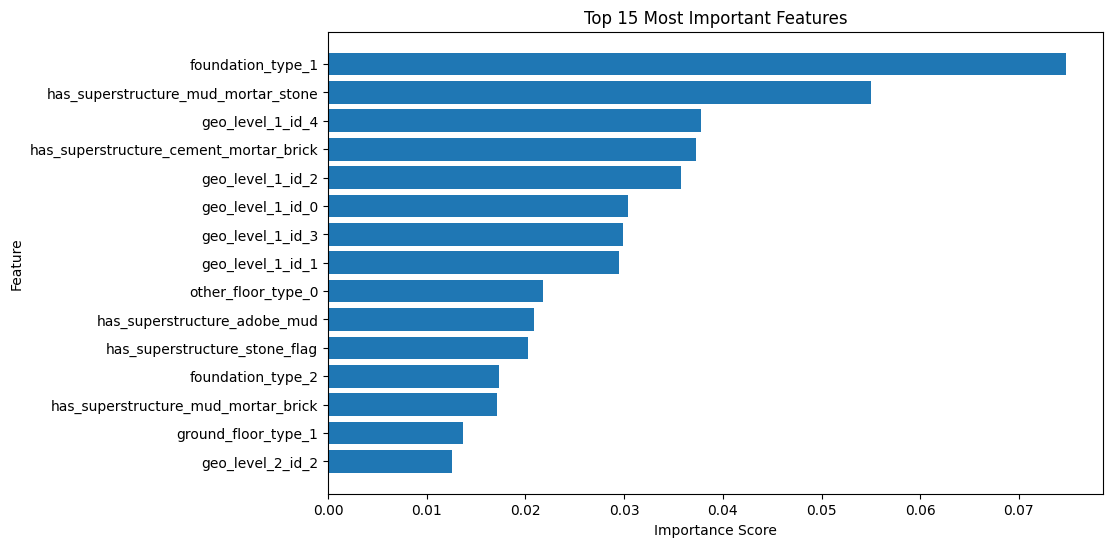

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance scores
feature_importance = model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 15 most important features
top_15_features = feature_importance_df.head(15)

# Plot the top 15 most important features
plt.figure(figsize=(10, 6))
plt.barh(top_15_features['Feature'], top_15_features['Importance'])
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()  # Invert the y-axis to show the most important features at the top
plt.show()